In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

In [3]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

# Global Setting

## Galaxy information

In [4]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [5]:
lam_range_temp = [4820, 5220]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [6]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [7]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [8]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 150
        Cut_RHS = 150

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [9]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Devide Radius bin

## Parameters pre-set

In [10]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4820, 5220])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [11]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## Bining

In [12]:
Radius_box = []

In [13]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        K_index = i*max(Galaxy_info.col)+j
        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        R = np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)
        Radius_box += [R]

In [14]:
int(max(Radius_box)/0.001)

10

In [15]:
RDB = []
for i in range(int(max(Radius_box)/0.001)+1):
    K_index = np.where(((np.array(Radius_box)/0.001)>=i) & ((np.array(Radius_box)/0.001)<(i+1)))
    RDB += [K_index]

## Spectrum calculate

In [16]:
RDB_spectrum = np.ndarray(shape=(Galaxy_info.spectra.shape[0], len(RDB)))

In [17]:
for Index_num in range(len(RDB)):
    RDB_spectrum[:,Index_num] = np.median(Galaxy_info.spectra[:,RDB[Index_num][0]],1)

# Fitting

## FTF

In [18]:
velscale_ratio = 2
velscale = Galaxy_info.velscale

velfield_RDB = np.ndarray(shape=len(RDB))
sigfield_RDB = np.ndarray(shape=len(RDB))
tempnum_RDB = np.ndarray(shape=len(RDB))
Bestfitfield_RDB = np.ndarray(shape=RDB_spectrum.shape)

optimal_templates_RDB = np.ndarray(shape=(npix,len(RDB)))

 36%|███▋      | 4/11 [00:01<00:03,  2.06it/s]

 Best Fit:       Vel     sigma
 comp.  0:        34        12
chi2/DOF: 0.5886; DOF: 1555; degree = 4; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 24; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150


100%|██████████| 11/11 [00:04<00:00,  2.47it/s]


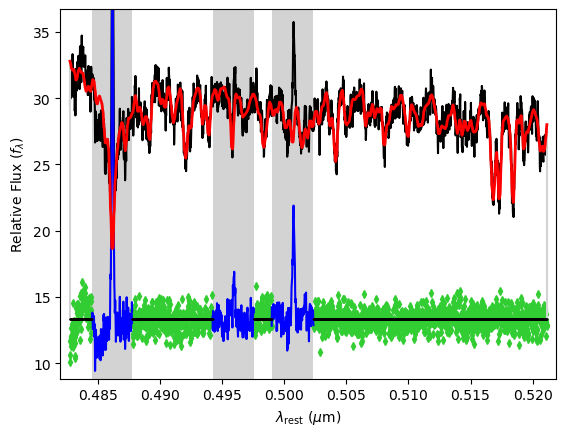

In [19]:
for i in tqdm(range(len(RDB))):
    plot_TF = True if (i == 3) else False
    tmpgalaxy = RDB_spectrum[:,i]
    noise = np.full_like(tmpgalaxy,0.1)
    noise = np.ones_like(tmpgalaxy)

    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
                            plot=plot_TF, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp,
                            quiet=not plot_TF)
                    # pp_field[i][j]=pp
    Bestfitfield_RDB[:,i]=pp.bestfit

    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
    optimal_templates_RDB[:,i] = pp.optimal_template
    velfield_RDB[i] = pp.sol[0]
    sigfield_RDB[i] = pp.sol[1]
    weights = pp.weights
    indwt = np.where(weights == np.max(weights))[0]
    tempnum_RDB[i] = indwt[0]

## Addtional parameters setting

In [20]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [21]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_28828\2058625761.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


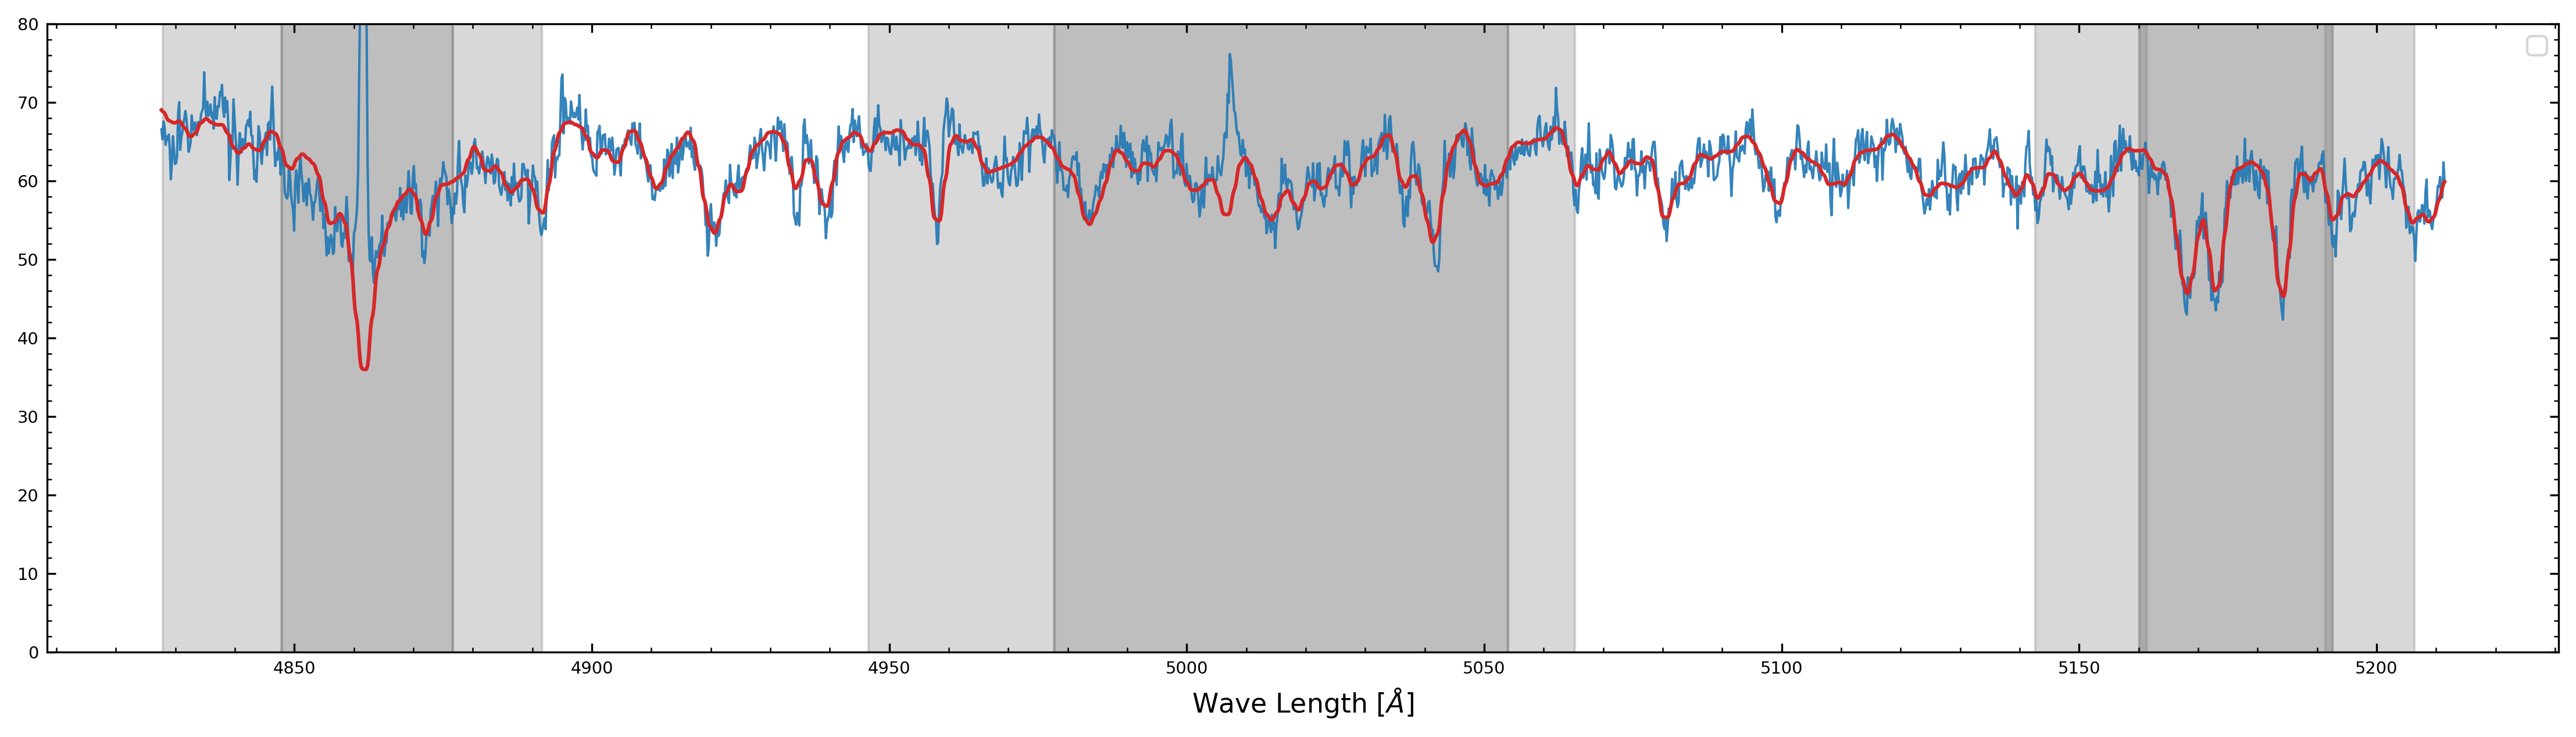

In [22]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,RDB_spectrum[:,0], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield_RDB[:,0], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,80)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF

### STF parameters setting

In [23]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [24]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

### Fitting

In [25]:
PP_box = []
for i in tqdm(range(len(RDB))):
        galaxy = RDB_spectrum[:,i]
        noise = np.ones_like(galaxy)

        template = optimal_templates_RDB[:,i]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield_RDB[i], sigfield_RDB[i]],
        [velfield_RDB[i], 50]]
        # start = [[0, 50],
        # [0, 200]]

        vlim = lambda x: velfield_RDB[i] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, Galaxy_info.velscale, start,
            plot=False,
            moments=moments, degree=8, mdegree=-1,
            component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

  0%|          | 0/11 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 9701.76


  9%|▉         | 1/11 [00:00<00:03,  3.07it/s]

differential_evolution step 2: f(x)= 9100.49
differential_evolution step 3: f(x)= 9046.37
differential_evolution step 4: f(x)= 8752.2
 Best Fit:       Vel     sigma
 comp.  0:        30        20
 comp.  1:        15        27
chi2/DOF: 4.152; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
         1       582       160
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      582.3       3.5      15    27
Comp:  1      [OIII]5007_d_(1)      213.2       4.4      15    27
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4924.2
differential_evolution step 2: f(x)= 3550.91
differential_evolution st

 18%|█▊        | 2/11 [00:00<00:03,  2.41it/s]

differential_evolution step 5: f(x)= 3200.71
differential_evolution step 6: f(x)= 3200.71
differential_evolution step 7: f(x)= 3140.56
 Best Fit:       Vel     sigma
 comp.  0:        31        20
 comp.  1:        22        31
chi2/DOF: 1.491; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.959       562       116
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      562.3       3.6      22    31
Comp:  1      [OIII]5007_d_(1)      154.7       4.6      22    31
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2669.23
differential_evolution step 2: f(x)= 2023.89
differential_evolution 

 27%|██▋       | 3/11 [00:01<00:03,  2.14it/s]

differential_evolution step 5: f(x)= 1889.68
differential_evolution step 6: f(x)= 1889.57
differential_evolution step 7: f(x)= 1888.91
 Best Fit:       Vel     sigma
 comp.  0:        34        20
 comp.  1:        30        32
chi2/DOF: 0.8966; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       329       107
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      329.3       3.7      30    32
Comp:  1      [OIII]5007_d_(1)      142.6       4.6      30    32
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1695.23
differential_evolution step 2: f(x)= 1449.39
differential_evolution

 36%|███▋      | 4/11 [00:01<00:03,  2.23it/s]

differential_evolution step 6: f(x)= 1366.74
 Best Fit:       Vel     sigma
 comp.  0:        34        20
 comp.  1:        35        35
chi2/DOF: 0.6484; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.03       271      82.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      270.6       3.8      35    35
Comp:  1      [OIII]5007_d_(1)      110.0       4.8      35    35
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1361.67
differential_evolution step 2: f(x)= 1338.98


 45%|████▌     | 5/11 [00:02<00:02,  2.27it/s]

differential_evolution step 3: f(x)= 1131.77
differential_evolution step 4: f(x)= 1131.77
differential_evolution step 5: f(x)= 1122.26
differential_evolution step 6: f(x)= 1120.05
 Best Fit:       Vel     sigma
 comp.  0:        32        20
 comp.  1:        29        40
chi2/DOF: 0.5314; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       288      66.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      287.8       3.9      29    40
Comp:  1      [OIII]5007_d_(1)      88.73       5.0      29    40
-----------------------------------------------------------------


 55%|█████▍    | 6/11 [00:02<00:01,  2.56it/s]

differential_evolution step 1: f(x)= 819.895
differential_evolution step 2: f(x)= 799.418
differential_evolution step 3: f(x)= 781.632
differential_evolution step 4: f(x)= 781.632
 Best Fit:       Vel     sigma
 comp.  0:        32        20
 comp.  1:        36        45
chi2/DOF: 0.3706; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       199      53.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      199.0       4.1      36    45
Comp:  1      [OIII]5007_d_(1)      71.44       5.2      36    45
-----------------------------------------------------------------


 73%|███████▎  | 8/11 [00:02<00:00,  3.79it/s]

differential_evolution step 1: f(x)= 788.269
 Best Fit:       Vel     sigma
 comp.  0:        27        20
 comp.  1:        34        71
chi2/DOF: 0.3728; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.02       112      23.5
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      111.8       5.0      34    71
Comp:  1      [OIII]5007_d_(1)      31.27       6.3      34    71
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 998.926
 Best Fit:       Vel     sigma
 comp.  0:        27        20
 comp.  1:        19        67
chi2/DOF: 0.4743; DOF: 2106; degree = 8; mdegree = 0
Global searc

 91%|█████████ | 10/11 [00:03<00:00,  4.96it/s]

differential_evolution step 1: f(x)= 1459.04
 Best Fit:       Vel     sigma
 comp.  0:        36        40
 comp.  1:        19        91
chi2/DOF: 0.6925; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.774      72.4       9.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      72.35       5.5      19    91
Comp:  1      [OIII]5007_d_(1)      12.37       7.0      19    91
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4378.1
 Best Fit:       Vel     sigma
 comp.  0:        65        20
 comp.  1:       106        20
chi2/DOF: 2.077; DOF: 2106; degree = 8; mdegree = 0
Global search 

100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

differential_evolution step 1: f(x)= 25723.5
 Best Fit:       Vel     sigma
 comp.  0:       -34        20
 comp.  1:       108        20
chi2/DOF: 12.19; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.713      40.9         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      40.86       3.3     108    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     108    20
-----------------------------------------------------------------


In [26]:
def CK_SpFT(I_index):
    K_index = I_index

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,RDB_spectrum[:,I_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:}]'.format(I_index))
    ax1.plot(lam_gal,Bestfitfield_RDB[:,I_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit) + np.std(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)
    MMSig = np.median(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit) - np.std(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Range:{:1.3f}$\pm${:1.3f}'.format(np.median(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit), np.std(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, RDB_spectrum[:,I_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, RDB_spectrum[:,I_index]-Bestfitfield_RDB[:,I_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    ax1.set_xlim(min(lam_gal), max(lam_gal))
    ax2.set_xlim(min(lam_gal), max(lam_gal))
    ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_ylim(0,max(RDB_spectrum[:,I_index])*1.1)
    ax2.set_ylim(min(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)*1.2, max(RDB_spectrum[:,I_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(RDB_spectrum[:,I_index]-Bestfitfield_RDB[:,I_index])*1.2, max(RDB_spectrum[:,I_index]-Bestfitfield_RDB[:,I_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()
    plt.show()
    # plt.savefig('./../FitPlot/Fit_05[24Nov07][VCC1588RDBFit]/'+galaxy_name+'Fig[{:}].pdf'.format(K_index), format='pdf', bbox_inches='tight')
    # plt.clf()
    # plt.close()

    PP_box[K_index] = []

In [27]:
# for i in tqdm(range(len(RDB))):
#         CK_SpFT(i)

In [28]:
# CK_SpFT(0)

# Data collect

## Spectrum Index

In [29]:
H_Beta_map = np.ndarray(shape=len(RDB))
Fe_5015_map = np.ndarray(shape=len(RDB))
Mg_b_map = np.ndarray(shape=len(RDB))

In [30]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [31]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [32]:
for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        H_Beta_map[i] = np.trapz(NS, x_wave[:,i]) / (RCB - LCB)

In [33]:
#Fe 5015

LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [34]:
#Fe 5015

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [35]:
#Fe 5015

for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
        LCB = Index_Wave.loc[1,'CBP_range'][0]
        RCB = Index_Wave.loc[1,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Fe_5015_map[i] = np.trapz(NS, x_wave[:,i]) / (RCB - LCB)

In [36]:
#Mg b

LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [37]:
#Mg b

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(RDB)))

In [38]:
#Mg b

for i in range(len(RDB)):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
        LCB = Index_Wave.loc[2,'CBP_range'][0]
        RCB = Index_Wave.loc[2,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Mg_b_map[i] = np.trapz(NS, x_wave[:,i]) / (RCB - LCB)

## OTP

In [39]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [40]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'K_index':[]})

In [41]:
RDB_spectrum_signal = np.median(RDB_spectrum[ np.where((lam_gal>5075) & (lam_gal<5125)) ] , 0)
RDB_spectrum_noise = np.std(RDB_spectrum[ np.where((lam_gal>5075) & (lam_gal<5125)) ], 0)

In [42]:
for Index_num in range(len(RDB)):
    K_index = RDB[Index_num][0]

    dx = []
    dy = []
    dr = []

    for k_index in K_index:
        i = int(k_index/max(Galaxy_info.col))
        j = k_index%max(Galaxy_info.col)

        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        dx += [Ori_ra - O_x]
        dy += [Ori_dec - O_y]
        dr += [np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)]
    R = np.mean(dr)

    rms = robust_sigma(RDB_spectrum[:,Index_num] - PP_box[Index_num].bestfit, zero=1)
    for p, name in enumerate(names):
        kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
        dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
        flux = (PP_box[Index_num].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
        an = np.max(PP_box[Index_num].gas_bestfit_templates[:, kk])/rms
        if(kk[0]):
            H_Beta_EL = flux
            H_Beta_EL_AN = an
        if(kk[1]):
            O_5007_EL = flux
            O_5007_EL_AN = an


    VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL],'H_beta_EL_ANR':[H_Beta_EL_AN],
                        'O_3_5007_EL_value':[O_5007_EL],'O_3_5007_EL_ANR':[O_5007_EL_AN],
                        'Component_Sol':[PP_box[Index_num].sol],
                        'H_beta_SI':[H_Beta_map[Index_num]],'Mg_b_SI':[Fe_5015_map[Index_num]],'Fe_5015_SI':[Mg_b_map[Index_num]],
                        'R':[R],'SNR':[RDB_spectrum_signal[Index_num]/RDB_spectrum_noise[Index_num]],'K_index':[K_index]})
    VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [43]:
RDB[1][0]

array([ 818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,
        829,  830,  831,  832,  833,  834,  902,  903,  904,  905,  906,
        907,  908,  918,  919,  920,  921,  922,  923,  924,  988,  989,
        990,  991,  992,  993, 1007, 1008, 1009, 1010, 1011, 1012, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1092, 1093, 1094, 1095, 1096,
       1097, 1098, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174,
       1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182], dtype=int64)

In [44]:
VNB_Sol.to_csv('./../FitData/Fit_DS_02[24Nov14][VCC1588]/'+galaxy_name+'_RDB_SFR.csv')